# RAPIDS SVR - CV 0.830
This notebook is a RAPIDS SVR starter notebook which achieves CV 0.830 and LB ???. (Let's submit to LB and see what score it achieves).

In this notebook, we extract text embeddings from 6 Hugging Face models. We **do not** finetune any LLM. The 6 LLM that we use here are models directly downloaded from Hugging Face (in notebook [here][1]) as is. Each of these model can accept token lengths of at least 1024 as discussed [here][3]. Therefore we can input the full essay instead of breaking into 512 chunks.

We extract 6 sets of embeddings and concatenate them into 5376 features! Afterward we use RAPIDS SVR to quickly train a 15-Fold support vector regression model on Kaggle's 2xT4 GPUs.

Then we apply threshold post process to convert the regression outputs into the 6 possible target labels of 1, 2, 3, 4, 5, 6 as discussed by MPWare [here][2]

[1]: https://www.kaggle.com/code/cdeotte/download-huggingface-models
[2]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/502279
[3]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/498571

# Fix RAPIDS Installation
To make RAPIDS work in a Kaggle notebook we need to do one of the following:
* Downgrade Pandas to 1.X
* Pip install the latest RAPIDS

I will do the first option since it is faster and RAPIDS v23.08.00 is recent enough for our SVR in this notebook. An example of pip install recent RAPIDS v24.02.00 is [here][1]

[1]: https://www.kaggle.com/code/premsagar/rapids-cudf-pandas-on-kaggle

In [10]:
!pip install --find-links /kaggle/input/downgrade-pandas /kaggle/input/downgrade-pandas/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in links: /kaggle/input/downgrade-pandas
Processing /kaggle/input/downgrade-pandas/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pandas is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


# Load Libraries and Data

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import numpy as np, gc, re 
import pandas as pd 

train = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv")
print("Train shape",train.shape)
display(train.head())
print()

test = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv")
print("Test shape",test.shape)
display(test.head())

Train shape (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3



Test shape (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


# Stratified 15 K Fold

In [12]:
from sklearn.model_selection import StratifiedKFold

FOLDS = 15
train["fold"] = -1
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
for fold,(train_index, val_index) in enumerate(skf.split(train,train["score"])):
    train.loc[val_index,"fold"] = fold
print('Train samples per fold:')
train.fold.value_counts().sort_index()

Train samples per fold:


0     1154
1     1154
2     1154
3     1154
4     1154
5     1154
6     1154
7     1154
8     1154
9     1154
10    1154
11    1154
12    1153
13    1153
14    1153
Name: fold, dtype: int64

# Generate Embeddings

In [13]:
from transformers import AutoModel,AutoTokenizer
import torch, torch.nn.functional as F
from tqdm import tqdm

In [14]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [15]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df,tokenizer,max_length):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

# Extract Embeddings

In [16]:
def get_embeddings(model_name='', max_length=1024, batch_size=32, compute_train=True, compute_test=True):

    global train, test

    DEVICE = "cuda:1" # EXTRACT EMBEDDINGS WITH GPU #2
    path = "/kaggle/input/download-huggingface-models/"
    disk_name = path + model_name.replace("/","_")
    model = AutoModel.from_pretrained( disk_name , trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained( disk_name , trust_remote_code=True)

    ds_tr = EmbedDataset(train, tokenizer, max_length)
    embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr,
                            batch_size=batch_size,
                            shuffle=False)
    ds_te = EmbedDataset(test, tokenizer, max_length)
    embed_dataloader_te = torch.utils.data.DataLoader(ds_te,
                            batch_size=batch_size,
                            shuffle=False)
    
    model = model.to(DEVICE)
    model.eval()

    # COMPUTE TRAIN EMBEDDINGS
    all_train_text_feats = []
    if compute_train:
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = model(input_ids=input_ids,attention_mask=attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)

    # COMPUTE TEST EMBEDDINGS
    all_test_text_feats = []
    if compute_test:
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = model(input_ids=input_ids,attention_mask=attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_test_text_feats.extend(sentence_embeddings)
        all_test_text_feats = np.array(all_test_text_feats)
    all_test_text_feats = np.array(all_test_text_feats)

    # CLEAR MEMORY
    del ds_tr, ds_te
    del embed_dataloader_tr, embed_dataloader_te
    del model, tokenizer
    del model_output, sentence_embeddings, input_ids, attention_mask
    gc.collect()
    torch.cuda.empty_cache()

    # RETURN EMBEDDINGS
    return all_train_text_feats, all_test_text_feats

In [17]:
# EMBEDDINGS TO LOAD/COMPUTE
# PARAMETERS = (MODEL_NAME, MAX_LENGTH, BATCH_SIZE)
# CHOOSE LARGEST BATCH SIZE WITHOUT MEMORY ERROR

models = [
    ('microsoft/deberta-base', 1024, 32),
    ('microsoft/deberta-large', 1024, 8),
    ('microsoft/deberta-v3-large', 1024, 8),
    ('allenai/longformer-base-4096', 1024, 32),
    ('google/bigbird-roberta-base', 1024, 32),
    ('google/bigbird-roberta-large', 1024, 8),
]

In [18]:
path = "/kaggle/input/essay-embeddings-v1/"
all_train_embeds = []
all_test_embeds = []

for (model, max_length, batch_size) in models:
    name = path + model.replace("/","_") + ".npy"
    if os.path.exists(name):
        _, test_embed = get_embeddings(model_name=model, max_length=max_length, batch_size=batch_size, compute_train=False)
        train_embed = np.load(name)
        print(f"Loading train embeddings for {name}")
    else:
        print(f"Computing train embeddings for {name}")
        train_embed, test_embed = get_embeddings(model_name=model, max_length=max_length, batch_size=batch_size, compute_train=True)
        np.save(name, train_embed)
    all_train_embeds.append(train_embed)
    all_test_embeds.append(test_embed)

del train_embed, test_embed

Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-base.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-large.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-v3-large.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/allenai_longformer-base-4096.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/google_bigbird-roberta-base.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/google_bigbird-roberta-large.npy


# Combine Feature Embeddings

In [19]:
all_train_embeds = np.concatenate(all_train_embeds,axis=1)
all_test_embeds = np.concatenate(all_test_embeds,axis=1)

gc.collect()
print('Our concatenated train embeddings have shape', all_train_embeds.shape )

Our concatenated train embeddings have shape (17307, 5376)


# Train RAPIDS cuML SVR
Documentation for RAPIDS SVR is [here][1]. Using RAPIDS support vector regression (SVR) is a great model when we have 1000s of features because it is quick and it naturally will perform feature selection and remove features to prevent overfitting.

Note that SVR model likes the inputs to be standardized so that each feature is rougly mean 0 and std 1. We approximate this by performing L2 norm on the extracted embeddings.

[1]: https://docs.rapids.ai/api/cuml/stable/api.html#support-vector-machines

In [20]:
# %pip install --upgrade pandas dask_cudf cuml

In [21]:
from cuml.svm import SVR
import cuml
print('RAPIDS version',cuml.__version__)

/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.B

RAPIDS version 23.08.00


In [22]:
from sklearn.metrics import cohen_kappa_score

oof = np.zeros(len(train), dtype='float32')
test_preds = np.zeros((len(test),FOLDS), dtype='float32')

def comp_score(y_true,y_pred):
    p = y_pred.clip(1,6).round(0)
    m = cohen_kappa_score(y_true, p, weights='quadratic')
    return m

for fold in range(FOLDS):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    train_index = train["fold"] != fold
    valid_index = train["fold"] == fold
    
    X_train = all_train_embeds[train_index,]
    y_train = train.loc[train_index,'score'].values
    X_valid = all_train_embeds[valid_index,]
    y_valid = train.loc[valid_index,'score'].values
    X_test = all_test_embeds
    
    model = SVR(C=10)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    test_preds[:,fold] = model.predict(X_test)
    oof[valid_index] = preds

    score = comp_score(y_valid, preds)    
    print(f"=> QWK score: {score}")
    print()
    
print('#'*25)
score = comp_score(train.score.values, oof)
print('Overall CV QWK score =',score)

#########################
### Fold 1
#########################
=> QWK score: 0.825272897540118

#########################
### Fold 2
#########################
=> QWK score: 0.8129478734441793

#########################
### Fold 3
#########################
=> QWK score: 0.8138396908082676

#########################
### Fold 4
#########################
=> QWK score: 0.8150806201631843

#########################
### Fold 5
#########################
=> QWK score: 0.8313629599552008

#########################
### Fold 6
#########################
=> QWK score: 0.8323657672089597

#########################
### Fold 7
#########################
=> QWK score: 0.8032320433842695

#########################
### Fold 8
#########################
=> QWK score: 0.8302620794858944

#########################
### Fold 9
#########################
=> QWK score: 0.8162161633031709

#########################
### Fold 10
#########################
=> QWK score: 0.8287489505622295

#########################
### 

# Find QWK Thresholds
The target labels are 1,2,3,4,5,6. So there are 5 thresholds. There is a threshold to decide between prediction 1 versus 2. For example if we have regression prediction 1.3, should it become final target 1 or 2? Where should the cutoff be?

The algorithm below determines that 1.749 is the optimal cutoff for our SVR in this notebook. A different model may have different optimal threshold. This threshold says when regression prediction is between 0 and 1.749 then we predict 1. And when regression prediction is between 1.749 and the next threshold of 2.533 then we predict 2. The other thresholds decide when to predict 3,4,5,6.

In [23]:
def find_thresholds(true, pred, steps=50):

    # SAVE TRIALS FOR PLOTTING
    xs = [[],[],[],[],[]]
    ys = [[],[],[],[],[]]

    # COMPUTE BASELINE METRIC
    threshold = [1.5, 2.5, 3.5, 4.5, 5.5]
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")

    # FIND FIVE OPTIMAL THRESHOLDS
    for k in range(5):
        for sign in [1,-1]:
            v = threshold[k]
            threshold2 = threshold.copy()
            stop = 0
            while stop<steps:

                # TRY NEW THRESHOLD
                v += sign * 0.001
                threshold2[k] = v
                pred2 = pd.cut(pred, [-np.inf] + threshold2 + [np.inf], 
                                labels=[1,2,3,4,5,6]).astype('int32')
                metric = cohen_kappa_score(true, pred2, weights="quadratic")

                # SAVE TRIALS FOR PLOTTING
                xs[k].append(v)
                ys[k].append(metric)

                # EARLY STOPPING
                if metric<=best:
                    stop += 1
                else:
                    stop = 0
                    best = metric
                    threshold = threshold2.copy()

    # COMPUTE FINAL METRIC
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")   

    # RETURN RESULTS
    threshold = [np.round(t,3) for t in threshold]
    return best, threshold, xs, ys

In [24]:
best, thresholds, xs, ys = find_thresholds(train.score.values, oof, steps=500)
print('Best thresholds are:', thresholds )
print('=> achieve Overall CV QWK score =', best )

Best thresholds are: [1.749, 2.533, 3.448, 4.278, 5.198]
=> achieve Overall CV QWK score = 0.830361501083172


# Display Threshold Trials
Below we observe the result of different thresholds and resultant CV QWK score. We note that the curves are pretty smooth which is good. If it is too bumpy, then the bumps are most likely random and will not generalize to unseen test data.

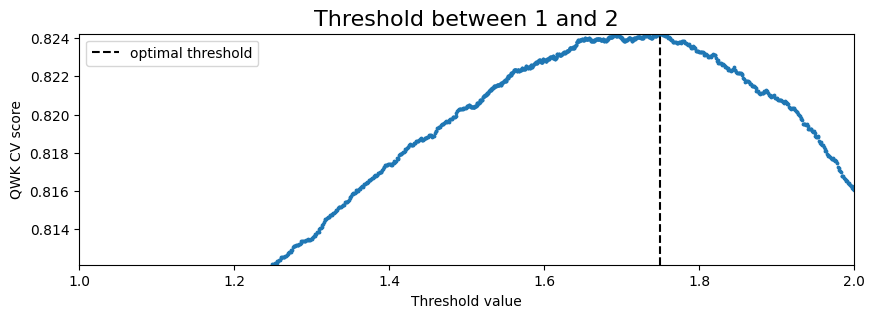

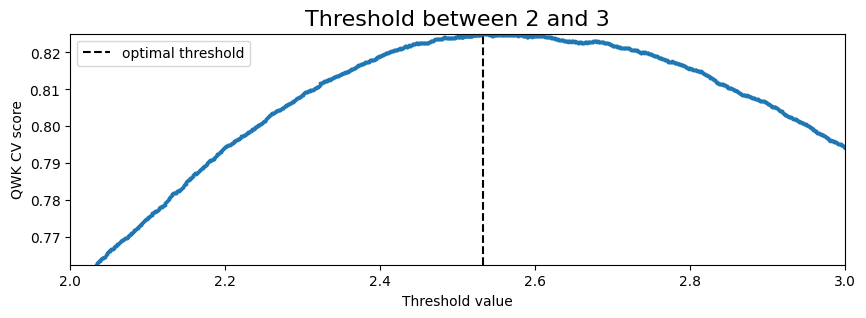

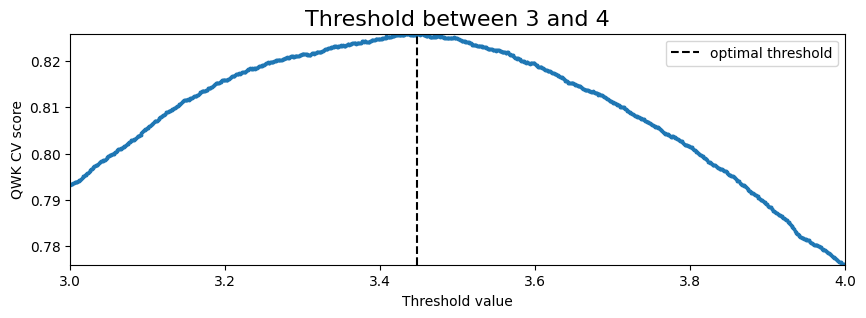

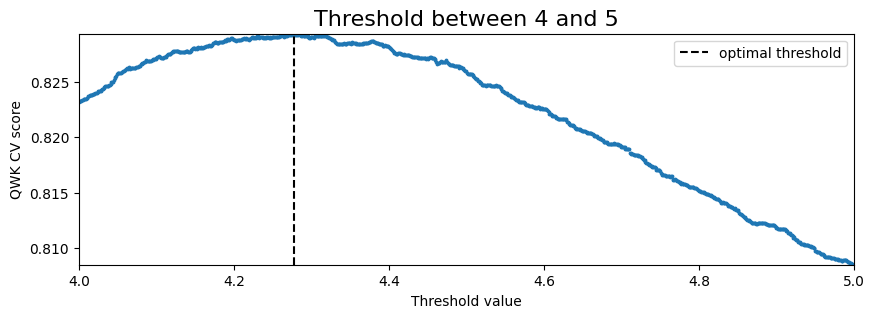

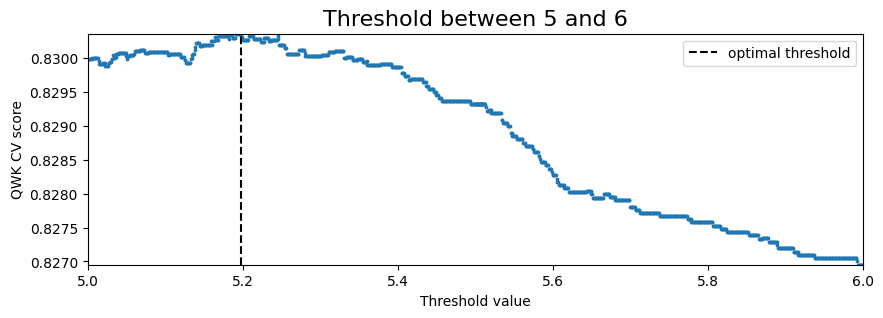

In [25]:
import matplotlib.pyplot as plt

diff = 0.5
for k in range(5):
    plt.figure(figsize=(10,3))
    plt.scatter(xs[k],ys[k],s=3)
    m = k+1.5
    plt.xlim((m-diff,m+diff))
    i = np.where( (np.array(xs[k])>m-diff)&(np.array(xs[k])<m+diff) )[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    plt.ylim((mn,mx))
    
    plt.plot([thresholds[k],thresholds[k]],[mn,mx],'--',
             color='black', label='optimal threshold')
    
    plt.title(f"Threshold between {k+1} and {k+2}",size=16)
    plt.xlabel('Threshold value',size=10)
    plt.ylabel('QWK CV score',size=10)
    plt.legend()
    plt.show()

# Create Submission CSV
We average our 15 fold predictions and apply optimal thresholds above to convert the 15 sets of regression predictions into 1 set of final target predictions.

In [26]:
test_preds = np.mean(test_preds,axis=1)
print('Test preds shape:', test_preds.shape )
print('First 3 test preds:',test_preds[:3] )

Test preds shape: (3,)
First 3 test preds: [2.4723973 2.9038346 4.4279027]


In [27]:
test_preds_pp = pd.cut(test_preds, [-np.inf] + thresholds + [np.inf], 
                       labels=[1,2,3,4,5,6]).astype('int32')
print('First 3 test preds after PP:',test_preds_pp[:3] )

First 3 test preds after PP: [2 3 5]


In [28]:
sub = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
sub["score"] = test_preds_pp
sub.score = sub.score.astype('int32')
sub.to_csv("submission.csv",index=False)
print("Submission shape", sub.shape )
sub.head()

Submission shape (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,5
